# Rule-Based System (RBS) Pipeline Example

An RBS Pipeline allows a user to configure a logical flow for decisioning events. Each stage in the pipeline consists of a set of rules which are linked to a decision. The decision that is applied to each event is dictated by the rule(s) that trigger first.

For example, in the case of approving and rejecting transactions for a e-commerce transaction use case, you might have 3 approve rules and 3 reject rules. These rules could be used in an RBS Pipeline to approve and reject transactions like so:

1. If any approve rules trigger, approve the transaction.
2. If no approve rules trigger, but any reject rules trigger, reject the transaction.
3. If no rules trigger, approve any remaining transactions.

This example shows how we can create this RBS Pipeline.

## Requirements

To run, you'll need the following:

* A set of rules that you want to use in the RBS (in this example, we'll generate these).
* A labelled, processed dataset (nulls imputed, categorical features encoded).

----

## Import packages

In [1]:
from iguanas.rule_generation import RuleGeneratorDT
from iguanas.rbs import RBSPipeline
from iguanas.metrics.classification import FScore

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Read in data

Let's read in some labelled, processed dummy data:

In [2]:
X_train = pd.read_csv(
    'dummy_data/X_train.csv', 
    index_col='eid'
)
y_train = pd.read_csv(
    'dummy_data/y_train.csv', 
    index_col='eid'
).squeeze()
X_test = pd.read_csv(
    'dummy_data/X_test.csv', 
    index_col='eid'
)
y_test = pd.read_csv(
    'dummy_data/y_test.csv', 
    index_col='eid'
).squeeze()

----

## Generate rules

Let's first generate some rules (both for approving and rejecting transactions) that we'll use later in our RBS Pipeline.

**Note**: in this dataset, positive cases in the target column refers to a fraudulent transaction, so we'll need to flip `y` when generating approve rules.

### Reject rules

In [3]:
fs = FScore(beta=1)

In [4]:
params = {
    'n_total_conditions': 4,
    'metric': fs.fit,
    'tree_ensemble': RandomForestClassifier(n_estimators=5, random_state=0, bootstrap=False),
    'precision_threshold': 0,
    'num_cores': 1,
    'target_feat_corr_types': 'Infer',
    'verbose': 0,
    'rule_name_prefix': 'RejectRule'
}

In [5]:
rg_reject = RuleGeneratorDT(**params)

In [6]:
X_rules_reject = rg_reject.fit(
    X=X_train, 
    y=y_train, 
    sample_weight=None
)

### Approve rules

In [7]:
params = {
    'n_total_conditions': 4,
    'metric': fs.fit,
    'tree_ensemble': RandomForestClassifier(n_estimators=2, random_state=0, bootstrap=False),
    'precision_threshold': 0,
    'num_cores': 1,
    'target_feat_corr_types': 'Infer',
    'verbose': 0,
    'rule_name_prefix': 'ApproveRule'
}

In [8]:
rg_approve = RuleGeneratorDT(**params)

In [9]:
X_rules_approve = rg_approve.fit(
    X=X_train, 
    y=(1-y_train), # We flip y here so non-fraudulent transactions become the target
    sample_weight=None
)

Now let's combine the binary columns of the approve and reject rules into one dataframe:

In [10]:
X_rules = pd.concat([X_rules_reject, X_rules_approve], axis=1)

In [11]:
X_rules.head()

,RejectRule_0,RejectRule_1,RejectRule_2,RejectRule_3,RejectRule_4,RejectRule_5,RejectRule_6,RejectRule_7,RejectRule_8,RejectRule_9,...,RejectRule_11,RejectRule_12,RejectRule_13,RejectRule_14,ApproveRule_0,ApproveRule_1,ApproveRule_2,ApproveRule_3,ApproveRule_4,ApproveRule_5
eid,,,,,,,,,,,,,,,,,,,,,
867-8837095-9305559,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
974-5306287-3527394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
584-0112844-9158928,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
956-4190732-7014837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
349-7005645-8862067,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


In [12]:
X_rules_reject.shape[1], X_rules_approve.shape[1]

(15, 6)

## Setting up the RBS Pipeline

Now, let's set up our RBS Pipeline using the rules we've generated. To reiterate our approach:

1. If any approve rules trigger, approve the transaction.
2. If no approve rules trigger, but any reject rules trigger, reject the transaction.
3. If no rules trigger, approve any remaining transactions.

To set up the pipeline using the logic above, we first need to create the `config` parameter. This is just a list which outlines the stages of the pipeline. Each stage should be defined using a tuple of two elements: 

1. The first element should be an integer which corresponds to the decision made at that stage (either `0` or `1`)
2. The second element should be a list that dictates which rules should trigger for that decision to be made.

In our example, the config will be:

In [13]:
config = [
    (0, X_rules_approve.columns.tolist()),
    (1, X_rules_reject.columns.tolist()),    
]

Here, the first stage is configured via the tuple in the first element of the list. This says to apply a decision of `0` (i.e. approve) to transactions where the approve rules have triggered. The second stage is configured via the tuple in the second element of the list. This says to apply a decision of `1` (i.e. reject) to transactions where the reject rules have triggered (**and no approve rules have triggered**).

We also need to specify the final decision to be made if no rules are triggered - this is set via the `final_decision` parameter. In our case this should be `0`, as we want to approve any remaining transactions:

In [14]:
final_decision = 0

With these parameters configured, we can now create our RBS Pipeline by instantiating the `RBSPipeline` class:

In [16]:
rbsp = RBSPipeline(
    config=config,
    final_decision=final_decision
)

We can then apply the pipeline to the dataset using the `predict` method:

In [17]:
y_pred = rbsp.predict(X_rules=X_rules)

### Outputs

The `predict` method returns the prediction of the pipeline by applying the pipeline to the given dataset.

We can use Sklearn's *classification_report* and *confusion_matrix* functions to generate some performance metrics for the pipeline:

In [18]:
print(
    classification_report(
        y_true=y_train, 
        y_pred=y_pred, 
        digits=4
    )
)

              precision    recall  f1-score   support

         0.0     0.9748    1.0000    0.9872      8651
         1.0     1.0000    0.0782    0.1450       243

    accuracy                         0.9748      8894
   macro avg     0.9874    0.5391    0.5661      8894
weighted avg     0.9755    0.9748    0.9642      8894



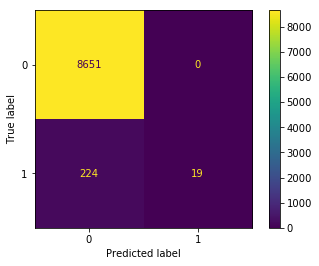

In [19]:
cm = ConfusionMatrixDisplay(
    confusion_matrix(
        y_true=y_train, 
        y_pred=y_pred
    )
)
cm.plot()

----